In [1]:
# Hermite
using Plots
using LinearAlgebra
using Combinatorics
using Distributed
using Base.Threads
function hermite(x::Vector{Float64}, n::Int)
    n == 0 && return ones(length(x))
    n == 1 && return 2 * x
    n >=0 || error("n must be non-negative")
    2 * x .* hermite(x, n-1) .- 2 * (n-1) * hermite(x, n-2)
end

# x = range(-10,10,2^10+1)
# a = hermite(x, 10)
# plot(x, a)

hermite (generic function with 1 method)

In [2]:
function ψ(x::Vector{Float64}, n::Int)
    1 / 2^(n/2) / factorial(big(n))^(1/2) / pi^(1/4) * exp.(-x.^2/2) .* hermite(x,n)
end
function ϵ(n::Int)
    n + 0.5
end
function ϵ_v(basis::Matrix{Int64})
    basis .+ 0.5
end
x = vcat(LinRange(-10,10,2^10+1))

1025-element Vector{Float64}:
 -10.0
  -9.98046875
  -9.9609375
  -9.94140625
  -9.921875
  -9.90234375
  -9.8828125
  -9.86328125
  -9.84375
  -9.82421875
   ⋮
   9.84375
   9.86328125
   9.8828125
   9.90234375
   9.921875
   9.94140625
   9.9609375
   9.98046875
  10.0

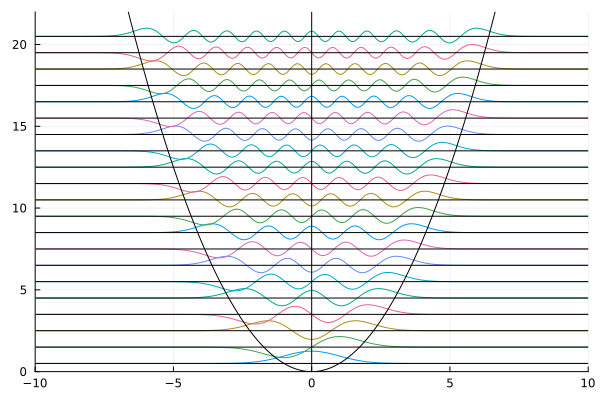

"/Users/wirawatkokaew/Library/CloudStorage/OneDrive-OIST/Desktop/Research_Project/QSQG/QSQG/tutorial/wf.pdf"

In [3]:
P = plot()
for i in 0:20
    plot!(x,ψ(x,i).+ϵ(i), label = i, xlims=(-10,10), ylims=(0,22), legend=:topright)
    plot!(x,ones(length(x)).*ϵ(i), linecolor=[:black], legend=false)
end
plot!(zeros(length(x)),LinRange(0,22,length(x)), linecolor=[:black], legend=false)
plot!(x,x.^2/2, linecolor=[:black], legend=false)
display(P)
savefig(P, "wf.pdf")

In [4]:
### check normalized wave function 
xf = 10; xi = -10; num_grid = 2^10+1
n = 0
x = vcat(LinRange(xi,xf,num_grid))
ψ(x,n)' * ψ(x,n) * (xf-xi)/num_grid

0.9990243902439023833572691767861112778009873359428729375877861321183688027933963

In [5]:
#generate bosonic fock basis via cut-off maximum energy
function list_basis(N, EnergyMax)
    state = zeros(Int,1,N)
    list = copy(state)
    Index = N
    while Index >= 1
        state[Index] = state[Index] + 1
        for i in range(Index+1, N)
            state[i] = state[Index]
        end
        Enegy = sum(ϵ_v(state))
        
        if Enegy <= EnergyMax
            list = vcat(list, state)
            Index = N
        else
            Index -= 1
        end
    end
    return list
end

list_basis (generic function with 1 method)

In [6]:
M_orb = 6
N = 3

l = list_basis(N,M_orb)

11×3 Matrix{Int64}:
 0  0  0
 0  0  1
 0  0  2
 0  0  3
 0  0  4
 0  1  1
 0  1  2
 0  1  3
 0  2  2
 1  1  1
 1  1  2

In [7]:
function list_to_fock(l)
    M = maximum(l)+1
    L = size(l,1)
    fock_list = zeros(Int, L, M)
    for i in 1:L, j in 1:M
        fock_list[i,j] = count(x -> x == j-1, l[i,:])
    end
    return fock_list
end
F = list_to_fock(l)

11×5 Matrix{Int64}:
 3  0  0  0  0
 2  1  0  0  0
 2  0  1  0  0
 2  0  0  1  0
 2  0  0  0  1
 1  2  0  0  0
 1  1  1  0  0
 1  1  0  1  0
 1  0  2  0  0
 0  3  0  0  0
 0  2  1  0  0

In [8]:
M = size(F,2)#; v = ϵ_v(vcat(0:M-1))
H0_L = ϵ_v(hcat(0:M-1)) .* Matrix(I,M,M)

5×5 Matrix{Float64}:
 0.5  0.0  0.0  0.0  0.0
 0.0  1.5  0.0  0.0  0.0
 0.0  0.0  2.5  0.0  0.0
 0.0  0.0  0.0  3.5  0.0
 0.0  0.0  0.0  0.0  4.5

In [9]:
U = zeros(M,M,M,M)

function Uijkl(i,j,k,l)
    xf = 10; xi = -10; num_grid = 2^12+1
    x = vcat(LinRange(xi,xf,num_grid))
    res = sum(ψ(x,i-1) .* ψ(x,j-1) .* ψ(x,k-1) .* ψ(x,l-1)) * (xf-xi)/num_grid
    return res
end

for i in 1:M
    for j in 1:M, k in 1:M, l in 1:M
        if mod(i+j+k+l, 2) == 1
            continue
        elseif U[i,j,k,l] != 0
            continue
        else
            U[i,j,k,l] = Uijkl(i,j,k,l)
            U[j,i,k,l] = U[i,j,k,l]
            U[i,j,l,k] = U[i,j,k,l]
            U[j,i,l,k] = U[i,j,k,l]
            U[k,l,i,j] = U[i,j,k,l]
        end
    end
end
# g = 5
# U = g/2 * U

In [10]:
function a(i::Int, fock_basis)
    if fock_basis[i] < 0
        ein_val = 0
    else
        ein_val = sqrt(fock_basis[i])
    end
    fock_basis[i] = fock_basis[i] - 1
    return [ein_val, fock_basis]
end

function ad(i::Int, fock_basis)
    if fock_basis[i]+1 < 0
        ein_val = 0
    else
        ein_val = sqrt(fock_basis[i]+1)
    end
    fock_basis[i] = fock_basis[i] + 1
    return [ein_val, fock_basis]
end

function num_op(i::Int, fock_basis)
    ein_val = fock_basis[i]
    return [ein_val, fock_basis] 
end


num_op (generic function with 1 method)

In [11]:
using PyCall
@pyimport numpy as np

nonzero_ind = np.transpose(np.nonzero(U))
nonzero_ind 

313×4 Matrix{Int64}:
 0  0  0  0
 0  0  0  2
 0  0  0  4
 0  0  1  1
 0  0  1  3
 0  0  2  0
 0  0  2  2
 0  0  2  4
 0  0  3  1
 0  0  3  3
 ⋮        
 4  4  1  3
 4  4  2  0
 4  4  2  2
 4  4  2  4
 4  4  3  1
 4  4  3  3
 4  4  4  0
 4  4  4  2
 4  4  4  4

In [12]:
F

11×5 Matrix{Int64}:
 3  0  0  0  0
 2  1  0  0  0
 2  0  1  0  0
 2  0  0  1  0
 2  0  0  0  1
 1  2  0  0  0
 1  1  1  0  0
 1  1  0  1  0
 1  0  2  0  0
 0  3  0  0  0
 0  2  1  0  0

In [13]:
U[1,1,1,1]

0.39884490615676543

In [14]:
Hint = zeros(size(F,1),size(F,1))
println(size(F,1))
F = collect(eachrow(F))
nonzero_ind =  collect(eachrow(nonzero_ind))
for k in 1:size(F,1), i in nonzero_ind
    Fs = copy(F[k])
    #println(Fs)
    ein_al, Fs = a(i[4].+1, Fs)
    ein_ak, Fs = a(i[3].+1, Fs)
    ein_adj, Fs = ad(i[2].+1, Fs)
    ein_adi, Fs = ad(i[1].+1, Fs)
    #print(U[i[1].+1,i[2].+1,i[3].+1,i[4].+1] )
    element = U[i[1].+1,i[2].+1,i[3].+1,i[4].+1] *  ein_adi * ein_adj * ein_ak * ein_al
    #println(Fs, i, element)
    #println(F)
    if Fs in F
        #println("p")
        #println(Fs)
        indices = indexin([Fs], F)
        #println(indices[1])
        ind = indices[1]
        Hint[ind,k] += element 
    end
    #println("---")
end


11


In [15]:
H0 = zeros(size(F,1),size(F,1))
println(size(F,1))
# F = collect(eachrow(F))
nonzero_ind = np.transpose(np.nonzero(H0_L))
nonzero_ind =  collect(eachrow(nonzero_ind))
for k in 1:size(F,1), i in nonzero_ind
    Fs = copy(F[k])
    #println(Fs)
    ein_aj, Fs = a(i[2].+1, Fs)
    ein_adi, Fs = ad(i[1].+1, Fs)
    #print(U[i[1].+1,i[2].+1,i[3].+1,i[4].+1] )
    element = H0_L[i[1].+1,i[2].+1] *  ein_adi * ein_aj
    #println(Fs, i, element)
    #println(F)
    if Fs in F
        #println("p")
        #println(Fs)
        indices = indexin([Fs], F)
        #println(indices[1])
        ind = indices[1]
        H0[ind,k] += element 
    end
    #println("---")
end


11


In [16]:
H = H0 + Hint

11×11 Matrix{Float64}:
  3.89307    0.0          -0.976967  …   0.518115   0.0      0.0
  0.0        4.89307       0.0           0.0        0.69082  0.0
 -0.976967   0.0           5.49422      -0.493545   0.0      0.398845
  0.0       -0.976967      0.0           0.0        0.0      0.0
  0.423039   0.0          -0.863525      0.0915906  0.0      0.0
  0.69082    0.0           0.282026  …   0.348989   0.0      0.564052
  0.0       -5.55112e-17   0.0           0.0        0.34541  0.0
 -0.598267   0.0           0.244242      0.215881   0.0      0.244242
  0.518115   0.0          -0.493545      7.20755    0.0      0.282026
  0.0        0.69082       0.0           0.0        6.2948   0.0
  0.0        0.0           0.398845  …   0.282026   0.0      7.49422

In [17]:
eigen_vals, _ = eigen(H)
eigen_vals

11-element Vector{Float64}:
 3.186389126337931
 4.207245838288779
 5.064952438615214
 5.207245838288774
 5.995668398087875
 6.893069436940592
 6.980625676357268
 6.995668398087883
 7.8930694369406
 7.969590057732962
 7.980625676357269

In [18]:
using Distributed
addprocs(4)

4-element Vector{Int64}:
 2
 3
 4
 5

In [19]:
V = zeros(M,M,M,M,M,M)

for i in 1:M

    function Vijklmn(i,j,k,l,m,n)
        xf = 10; xi = -10; num_grid = 2^10+1
        x = vcat(LinRange(xi,xf,num_grid))
        res = sum(ψ(x,i-1) .* ψ(x,j-1) .* ψ(x,k-1) .* ψ(x,l-1).* ψ(x,m-1).* ψ(x,n-1)) * (xf-xi)/num_grid
        return res
    end
    for j in 1:M, k in 1:M, l in 1:M, m in 1:M, n in 1:M
        if mod(i+j+k+l+m+n, 2) == 1
            continue
        elseif V[i,j,k,l,m,n] != 0
            continue
        else
            V[i,j,k,l,m,n] = Vijklmn(i,j,k,l,m,n)
            V[j,i,k,l,m,n] = V[i,j,k,l,m,n]
            V[j,k,i,l,m,n] = V[i,j,k,l,m,n]
            V[i,k,j,l,m,n] = V[i,j,k,l,m,n]
            V[k,j,i,l,m,n] = V[i,j,k,l,m,n]
            V[i,j,k,m,l,n] = V[i,j,k,l,m,n]
            V[i,j,k,m,n,l] = V[i,j,k,l,m,n]
            V[i,j,k,l,n,m] = V[i,j,k,l,m,n]
            V[i,j,k,n,l,m] = V[i,j,k,l,m,n]
            V[i,j,k,n,m,l] = V[i,j,k,l,m,n]
            V[l,m,n,i,j,k] = V[i,j,k,l,m,n]
        end
    end
end
# g = 5
# V = g/6 * V
print(size(V))

(5, 5, 5, 5, 5, 5)

In [20]:
@distributed for (N,H) in collect(Iterators.product(1:5:20,1:5:20))
    println("The N of this iteration in $N, $H")
end

Task (runnable, started) @0x000000031cedb9e0

In [21]:
Hint3 = zeros(size(F,1),size(F,1))
println(size(F,1))
nonzero_ind = np.transpose(np.nonzero(V))
nonzero_ind =  collect(eachrow(nonzero_ind))
@distributed for k in 1:size(F,1)
    
    for i in nonzero_ind
    Fs = copy(F[k])
    #println(Fs)

    ein_an, Fs = a(i[6].+1, Fs)
    ein_am, Fs = a(i[5].+1, Fs)
    ein_al, Fs = a(i[4].+1, Fs)
    ein_adk, Fs = ad(i[3].+1, Fs)
    ein_adj, Fs = ad(i[2].+1, Fs)
    ein_adi, Fs = ad(i[1].+1, Fs)
    #print(U[i[1].+1,i[2].+1,i[3].+1,i[4].+1] )
    element = V[i[1].+1,i[2].+1,i[3].+1,i[4].+1,i[5].+1,i[6].+1] *  ein_adi * ein_adj * ein_adk * ein_al * ein_am * ein_an
    #println(Fs, i, element)
    #println(F)
    if Fs in F
        #println("p")
        #println(Fs)
        indices = indexin([Fs], F)
        #println(indices[1])
        ind = indices[1]
        Hint3[ind,k] += element 
    end
    #println("---")
    end
end


11
      From worker 5:	The N of this iteration in 1, 16
      From worker 5:	The N of this iteration in 6, 16
      From worker 5:	The N of this iteration in 11, 16
      From worker 5:	The N of this iteration in 16, 16


Task (runnable, started) @0x000000010c351140

In [22]:
H = H0 + Hint3

      From worker 4:	The N of this iteration in 1, 11
      From worker 4:	The N of this iteration in 6, 11
      From worker 4:	The N of this iteration in 11, 11
      From worker 4:	The N of this iteration in 16, 11
      From worker 2:	The N of this iteration in 1, 1
      From worker 3:	The N of this iteration in 1, 6
      From worker 3:	The N of this iteration in 6, 6
      From worker 3:	The N of this iteration in 11, 6
      From worker 3:	The N of this iteration in 16, 6


11×11 Matrix{Float64}:
 1.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  2.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  3.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  4.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  5.5  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  3.5  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  4.5  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  5.5  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  5.5  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  4.5  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  5.5

In [23]:
eigen_vals, _ = eigen(H)
eigen_vals

      From worker 2:	The N of this iteration in 6, 1
      From worker 2:	The N of this iteration in 11, 1
      From worker 2:	The N of this iteration in 16, 1


11-element Vector{Float64}:
 1.4999999999999998
 2.5
 3.5
 3.5000000000000004
 4.5
 4.5
 4.5
 5.5
 5.5
 5.5
 5.500000000000001

In [24]:
function get_H2(g2, U, F)
    U = g2/2*U
    Hint = zeros(size(F,1),size(F,1))
    nonzero_ind = np.transpose(np.nonzero(U))
    nonzero_ind =  collect(eachrow(nonzero_ind))
    for k in 1:size(F,1), i in nonzero_ind
        Fs = copy(F[k])
        #println(Fs)
        ein_al, Fs = a(i[4].+1, Fs)
        ein_ak, Fs = a(i[3].+1, Fs)
        ein_adj, Fs = ad(i[2].+1, Fs)
        ein_adi, Fs = ad(i[1].+1, Fs)
        #print(U[i[1].+1,i[2].+1,i[3].+1,i[4].+1] )
        element = U[i[1].+1,i[2].+1,i[3].+1,i[4].+1] *  ein_adi * ein_adj * ein_ak * ein_al
        #println(Fs, i, element)
        #println(F)
        if Fs in F
            #println("p")
            #println(Fs)
            indices = indexin([Fs], F)
            #println(indices[1])
            ind = indices[1]
            Hint[ind,k] += element 
        end
        #println("---")
    end
    return Hint
end

function get_H3(V, F)
    V = g3/6*V
    Hint3 = zeros(size(F,1),size(F,1))
    nonzero_ind = np.transpose(np.nonzero(V))
    nonzero_ind =  collect(eachrow(nonzero_ind))
    for k in 1:size(F,1), i in nonzero_ind
        Fs = copy(F[k])
        #println(Fs)
    
        ein_an, Fs = a(i[6].+1, Fs)
        ein_am, Fs = a(i[5].+1, Fs)
        ein_al, Fs = a(i[4].+1, Fs)
        ein_adk, Fs = ad(i[3].+1, Fs)
        ein_adj, Fs = ad(i[2].+1, Fs)
        ein_adi, Fs = ad(i[1].+1, Fs)
        #print(U[i[1].+1,i[2].+1,i[3].+1,i[4].+1] )
        element = V[i[1].+1,i[2].+1,i[3].+1,i[4].+1,i[5].+1,i[6].+1] *  ein_adi * ein_adj * ein_adk * ein_al * ein_am * ein_an
        #println(Fs, i, element)
        #println(F)
        if Fs in F
            #println("p")
            #println(Fs)
            indices = indexin([Fs], F)
            #println(indices[1])
            ind = indices[1]
            Hint3[ind,k] += element 
        end
        #println("---")
    end
    return Hint3
end

function spectrum(g2, g3, H0, U, V, F)
    H = H0
    if g2 != 0
        H2 = get_H2(g2, U, F)
        H = H0 + H2 
    end
    if g3 != 0
        H3 = get_H3(g3, V, F)
        H = H0 + H3
    end
    eigen_vals, _ = eigen(H)
    return eigen_vals
end


spectrum (generic function with 1 method)

In [25]:
spectrum(10,0,H0,U,V,F)

11-element Vector{Float64}:
  6.715168418828192
  7.966507085465549
  8.871257806988487
  8.96650708546556
 11.97834199043936
 12.978341990439356
 16.465347184702964
 17.465347184702974
 19.972850487764614
 20.97285048776465
 23.5182318876138